# Example of applying LSTM

In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn import metrics as s_metrics

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import EarlyStopping


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras import metrics


import warnings
import numpy as np
from collections import OrderedDict

import os

from lob_data_utils import lob, db_result, gdf_pca
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data_length = 24000
stock = '9761'
gdf_filename_pattern = 'gdf_{}_r{}_s{}_K50'
gdf_parameters = [(0.1, 0.1), (0.01, 0.1), (0.1, 0.5), (0.01, 0.5)]

In [3]:
gdf_dfs = []
for r, s in gdf_parameters:
    gdf_dfs.append(gdf_pca.SvmGdfResults(
        stock,  r=r, s=s, data_length=data_length, gdf_filename_pattern=gdf_filename_pattern))

In [4]:
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper
import tensorflow as tf
auc_roc = as_keras_metric(tf.metrics.auc)

In [5]:
def split_sequences(sequences, labels, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences):
            break
        seq_x = sequences[i:end_ix]
        lab = labels[end_ix - 1]
        X.append(seq_x)
        y.append(lab)
    return np.array(X), np.array(y)

In [6]:
gdf_df = gdf_dfs[1] # this is a container for data and useful methods
weights = gdf_df.get_classes_weights()

train_size = int(len(gdf_df.df) * 0.8)
df = gdf_df.df.iloc[: train_size]
df_val = gdf_df.df.iloc[train_size:]
df_test = gdf_df.df_test


X_train = df[[gdf for gdf in df.columns if 'gdf' in gdf or 'queue' in gdf]].values
y_train = df['mid_price_indicator'].values

X_val = df_val[[gdf for gdf in df.columns if 'gdf' in gdf or 'queue' in gdf]].values
y_val = df_val['mid_price_indicator'].values

X_test = df_test[[gdf for gdf in df_test.columns if 'gdf' in gdf or 'queue' in gdf]].values
y_test = df_test['mid_price_indicator'].values

# apply pca (fit to train set, apply to train and test)
pca = gdf_df.get_pca('pca_n_gdf_que')
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
X_val = pca.transform(X_val)
          
# prepare data to use time-steps
number_of_steps = 8
X_train, y_train = split_sequences(X_train, y_train, n_steps=number_of_steps)
X_test, y_test = split_sequences(X_test, y_test, n_steps=number_of_steps)
X_val, y_val = split_sequences(X_val, y_val, n_steps=number_of_steps)
print('train input shape', X_train.shape)

train input shape (15352, 8, 3)


In [7]:
max_features = 1024
model = Sequential()

# number of PCA components is number of features
model.add(LSTM(16, input_shape=(number_of_steps, pca.n_components))) 
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc_roc, metrics.binary_accuracy])

history = model.fit(X_train, y_train, shuffle=False, epochs=30, batch_size=300, class_weight=weights,
                   validation_data=(X_val, y_val), 
                    callbacks=[EarlyStopping(monitor='loss',
                              min_delta=0, patience=0, verbose=0, mode='auto')])
print(model.summary())

Train on 15352 samples, validate on 3833 samples
Epoch 1/30
15352/15352 [==============================] - 2s 151us/step - loss: 0.6921 - auc: 0.4208 - binary_accuracy: 0.3651 - val_loss: 0.6946 - val_auc: 0.4769 - val_binary_accuracy: 0.4759
Epoch 2/30
15352/15352 [==============================] - 1s 53us/step - loss: 0.6877 - auc: 0.4964 - binary_accuracy: 0.5101 - val_loss: 0.6877 - val_auc: 0.5188 - val_binary_accuracy: 0.5354
Epoch 3/30
15352/15352 [==============================] - 1s 50us/step - loss: 0.6851 - auc: 0.5257 - binary_accuracy: 0.5472 - val_loss: 0.6839 - val_auc: 0.5376 - val_binary_accuracy: 0.5554
Epoch 4/30
15352/15352 [==============================] - 1s 44us/step - loss: 0.6826 - auc: 0.5420 - binary_accuracy: 0.5623 - val_loss: 0.6813 - val_auc: 0.5502 - val_binary_accuracy: 0.5630
Epoch 5/30
15352/15352 [==============================] - 1s 49us/step - loss: 0.6803 - auc: 0.5534 - binary_accuracy: 0.5668 - val_loss: 0.6792 - val_auc: 0.5593 - val_binary_ac

In [8]:
pred_test = model.predict_classes(X_test)
pred = model.predict_classes(X_train)


print('ROC auc train', s_metrics.roc_auc_score(y_train, pred), '\tROC auc test:', 
      s_metrics.roc_auc_score(y_test, pred_test), )
print('MCC train', s_metrics.matthews_corrcoef(y_train, pred), '\t\t MCC test:', 
      s_metrics.matthews_corrcoef(y_test, pred_test), )

ROC auc train 0.5802735099271067 	ROC auc test: 0.5593060361985656
MCC train 0.14654018749572134 		 MCC test: 0.10938704486805462


In [9]:
## Plots

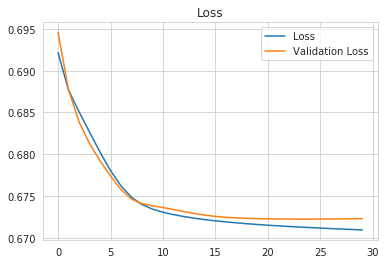

In [10]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

Text(0.5,1,'ROC area score')

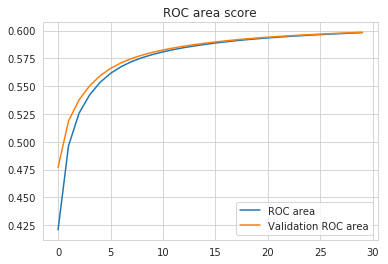

In [11]:
plt.plot(history.history['auc'], label='ROC area')
plt.plot(history.history['val_auc'], label='Validation ROC area')
plt.legend()
plt.title('ROC area score')

Text(0.5,1,'Accuracy')

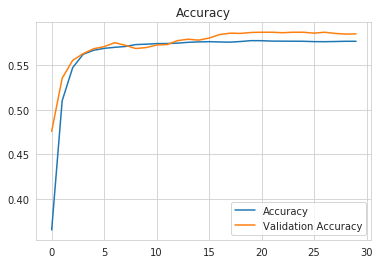

In [12]:
plt.plot(history.history['binary_accuracy'], label='Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

In [13]:
## Layers

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 16)                1280      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,297
Trainable params: 1,297
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.layers[0].trainable_weights[0]
units = int(int(model.layers[0].trainable_weights[0].shape[1])/4)
print("No units: ", units)
print(model.layers)

No units:  16
[<keras.layers.recurrent.LSTM object at 0x7f9cfa5c9ef0>, <keras.layers.core.Dense object at 0x7f9d513c8ba8>]


In [16]:
def plot_layer(m, ll):
    W = m.layers[ll].get_weights()[0]
    U = m.layers[ll].get_weights()[1]
    b = m.layers[ll].get_weights()[2]

    W_i = W[:, :units]
    W_f = W[:, units: units * 2]
    W_c = W[:, units * 2: units * 3]
    W_o = W[:, units * 3:]

    U_i = U[:, :units]
    U_f = U[:, units: units * 2]
    U_c = U[:, units * 2: units * 3]
    U_o = U[:, units * 3:]

    b_i = b[:units]
    b_f = b[units: units * 2]
    b_c = b[units * 2: units * 3]
    b_o = b[units * 3:]
    _, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16, 4))
    ax1.plot(U.ravel())
    ax2.plot(W.ravel())
    ax3.plot(b.ravel())
    ax1.set_title(f'Update gate weights for layer {ll}')
    ax2.set_title(f'Weights for layer {ll}')
    ax3.set_title(f'Bias for layer {ll}')


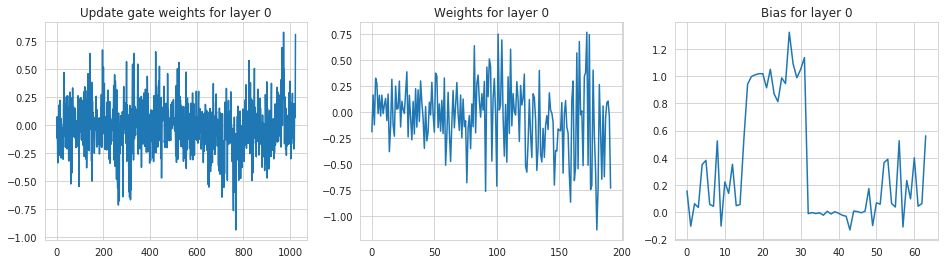

In [17]:
plot_layer(model, 0)